In [24]:
import numpy as np
import os 
import random
from pathlib import Path
from keras.preprocessing import image
import matplotlib.pyplot as plt

### Preparing Dataset

In [65]:
p = Path("../Downloads/Images/Images/") #setting path of folder
print(p)
dirs = p.glob("*")

labels_dict = {"cat":0,"dog":1,"horse":2,"human":3}

image_data = []
labels = []

for folder_dir in dirs:
    print(folder_dir)
    
    label = str(folder_dir).split("\\")[-1][:-1]
    print(label)
    
    for img_path in folder_dir.glob("*.jpg"):
        #print(img_path)
        img = image.load_img(img_path,target_size=(32,32))  #to load image from the system and resizing to 32x32
        img_array = image.img_to_array(img)                 
        image_data.append(img_array)        
        labels.append(labels_dict[label]) 



..\Downloads\Images\Images
..\Downloads\Images\Images\cats
cat
..\Downloads\Images\Images\dogs
dog
..\Downloads\Images\Images\horses
horse
..\Downloads\Images\Images\humans
human


In [66]:

print(len(image_data))
print(len(labels))

808
808


In [67]:
image_data = np.array(image_data,dtype='float32')/255.0
labels = np.array(labels)

combined = list(zip(image_data,labels))   #zip the image_data and laebels to shuffle
random.shuffle(combined)

image_data[0:],labels[0:] = zip(*combined)  #unzip the shuffled data

### Function to visualize data

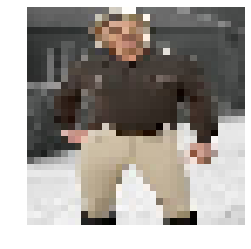

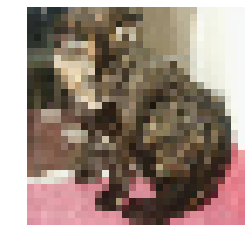

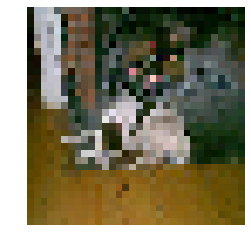

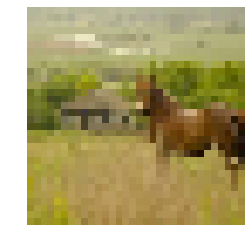

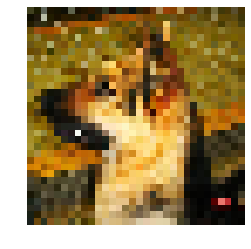

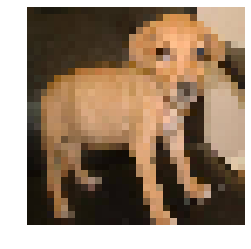

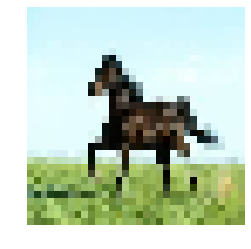

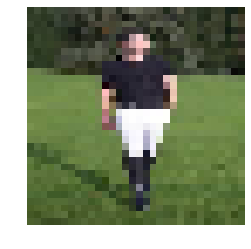

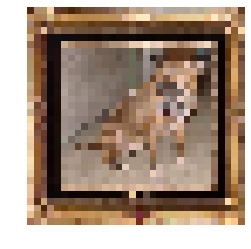

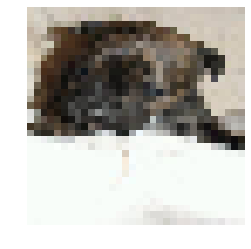

In [68]:
def drawImg(img):
    
    plt.imshow(img)
    plt.axis("off")
    plt.show()    
    
    return 

for i in range(10):
    drawImg(image_data[i])

### SVM classifier

In [70]:
class SVM:

    
    def __init__(self,C=1.0):         #init method to initialize the values
        self.C = C
        self.W = 0
        self.b = 0
    
    def hingeLoss(self,W,b,X,Y):      #to calculate the hingeLoss
        loss  = 0.0
        
        loss += .5*np.dot(W,W.T)
        
        m = X.shape[0]
        
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))
            
        return loss[0][0]
    
    
    def fit(self,X,Y,batch_size=50,learning_rate=0.001,maxItr=500):       #to train the model
        
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate
        c = self.C
        
        W = np.zeros((1,no_of_features))
        bias = 0
        
        
        #Training from here...
        
        losses = []
        
        for i in range(maxItr):       #Training Loop

            l = self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            
            for batch_start in range(0,no_of_samples,batch_size):   #Batch Gradient Descent(Paper) with random shuffling

                gradw = 0
                gradb = 0
                
                
                for j in range(batch_start,batch_start+batch_size):   #Iterate over all examples in the mini batch
                    if j<no_of_samples:
                        i = ids[j]
                        ti =  Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                            
                #Gradient for the batch is ready! Update W,B
                
                W = W - n*W + n*gradw
                bias = bias + n*gradb
                
        #Assigning the values to weights and bias Variable of class 
        
        self.W = W
        self.b = bias
        return W,bias,losses

### Convert data for One-for-One classifcation!

In [71]:
M = image_data.shape[0] 
image_data = image_data.reshape(M,-1)    #reshaping the data

print(image_data.shape)
print(labels.shape)

(808, 3072)
(808,)


In [72]:
CLASSES = len(np.unique(labels))
print(CLASSES)


"""Function to Create the dictionary of labels as Keys 
    and their corresponding list of images as Values """

def classWiseData(x,y):      
    data = {}
    
    for i in range(CLASSES):
        data[i] = []
        
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
    
    for k in data.keys():
        data[k] = np.array(data[k])
        
    return data

4


In [73]:
"""Funtion which take Data of two classes and combine them into one matrix"""

def getDataPairForSVM(d1,d2):

    l1,l2 = d1.shape[0],d2.shape[0]
    
    samples = l1+l2
    features = d1.shape[1]
    
    #To store the new Combined data
    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,))
    
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    
    data_labels[:l1] = -1
    data_labels[l1:] = +1
    
    return data_pair,data_labels

### Training nC2 classifiers 

In [74]:
mySVM = SVM()

def trainSVMs(x,y):
    
    svm_classifiers = {}
    for i in range(CLASSES):
        svm_classifiers[i] = {}
        for j in range(i+1,CLASSES):
            xpair,ypair = getDataPairForSVM(data[i],data[j])
            wts,b,loss = mySVM.fit(xpair,ypair,learning_rate=0.00001,maxItr=1000)
            svm_classifiers[i][j] = (wts,b)
    
                #plt.plot(loss)
                #plt.show()
            
    return svm_classifiers

### Prediction

In [75]:
def binaryPredict(x,w,b):       #Prediction between 2 classes

    z  = np.dot(x,w.T) + b      #Generating Hypothesis

    if z>=0:
        return 1
    else:
        return -1
    

def predict(x):                #Prediction using all clasifiers
    
    count = np.zeros((CLASSES,))
    
    for i in range(CLASSES):
        for j in range(i+1,CLASSES):
            w,b = svm_classifiers[i][j]

            #Take a majority prediction 
            z = binaryPredict(x,w,b)
            
            if(z==1):
                count[j] += 1
            else:
                count[i] += 1
    
    final_prediction = np.argmax(count)
    
    return final_prediction


### Accuracy

In [76]:
def accuracy(x,y):
    
    count = 0
    for i in range(x.shape[0]):
        prediction = predict(x[i])

        #Checking Predictions with Labels
        if(prediction==y[i]):
            count += 1
            
    return count/x.shape[0]


In [77]:
data = classWiseData(image_data,labels)
svm_classifiers = trainSVMs(image_data,labels)

print("Accuracy of mySVM model: ",accuracy(image_data,labels))

Accuracy of mySVM model:  0.5866336633663366


# Using SK Learn

In [78]:
from sklearn import svm

svm_classifier = svm.SVC(kernel='linear',C=1.0)

svm_classifier.fit(image_data,labels)

print("Accuracy of sklearn SVM model: ",svm_classifier.score(image_data,labels))s

Accuracy of sklearn SVM model:  0.6237623762376238
